In [9]:
import tensorflow as tf

from keras import backend  as K
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [10]:
# Data from https://www.kaggle.com/datasets/alfrandom/protein-secondary-structure

MAX_SEQ_LEN = 128

df = pd.read_csv('ss_data/seq_cleaned.csv')
df = df[(df.seq.str.len() <= MAX_SEQ_LEN) & (~df.has_nonstd_aa)]

len(df)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

<Axes: >

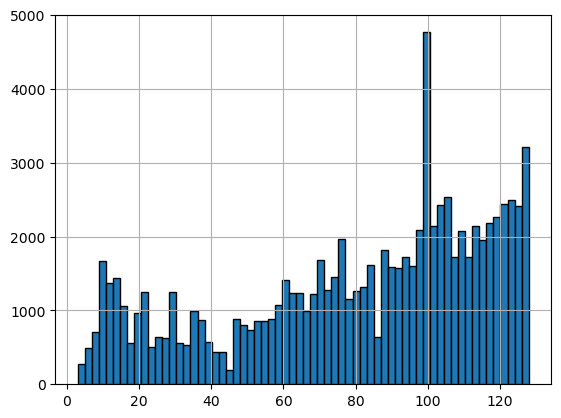

In [ ]:
df.seq.apply(lambda x: len(x)).hist(bins=64, edgecolor='black')

In [ ]:
tokenizer_in = Tokenizer(char_level=True)
tokenizer_in.fit_on_texts(df.seq)
vocab_size_in = len(tokenizer_in.word_index) + 1 

X = tokenizer_in.texts_to_sequences(df.seq)
X = pad_sequences(X, maxlen=MAX_SEQ_LEN, padding='post')

In [ ]:
tokenizer_out = Tokenizer(char_level=True, num_words=9)
tokenizer_out.fit_on_texts(df.sst3)
vocab_size_out = len(tokenizer_out.word_index) + 1

y = tokenizer_out.texts_to_sequences(df.sst3)
y = pad_sequences(y, maxlen=MAX_SEQ_LEN, padding='post')
y = to_categorical(y)

X.shape, y.shape

((88751, 128), (88751, 128, 4))

In [ ]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
n_words = len(tokenizer_in.word_index) + 1
n_tags = len(tokenizer_out.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(MAX_SEQ_LEN,))
mbed = Embedding(input_dim=n_words, output_dim=128, input_length=MAX_SEQ_LEN)(input)
comp = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(mbed)
final_comp = TimeDistributed(Dense(n_tags, activation="softmax"))(comp)
model = Model(input, final_comp)
model.summary()

21 4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          2688      
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          98816     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 128, 4)            516       
 ributed)                                                        
                                                                 
Total params: 102020 (398.52 KB)
Trainable params: 102020 (398.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
218/555 [==========>...................] - ETA: 2:01 - loss: 0.5989 - accuracy: 0.7281 - q3_acc: 0.5698

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_val, y_val)

42/42 [==============================] - 0s 7ms/step - loss: 0.2917 - accuracy: 0.8908 - q3_acc: 0.7926


[0.2916891276836395, 0.8908005356788635, 0.7925929427146912]

In [ ]:
tokenizer_out.word_index

{'c': 1, 'h': 2, 'e': 3}

In [ ]:
def plot_prediction(i):
    p1 = np.argmax(model.predict(X_test[i:i+1]), axis=-1)[0]
    y1 = np.argmax(y_test[i:i+1], axis=-1)[0]
    
    c = np.array([p1, y1])

    _, ax = plt.subplots(figsize=(16, 1))

    sns.heatmap(c, ax=ax, cmap='viridis', xticklabels=[], linewidths=.55, linecolor='black', cbar=False)
    ax.set_yticklabels(['Predicted', 'True'], rotation=0)
    
    labels = ['P', 'C', 'H', 'E']
    colors = ['#440154', '#31688e', '#35b779', '#fde725']
    patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

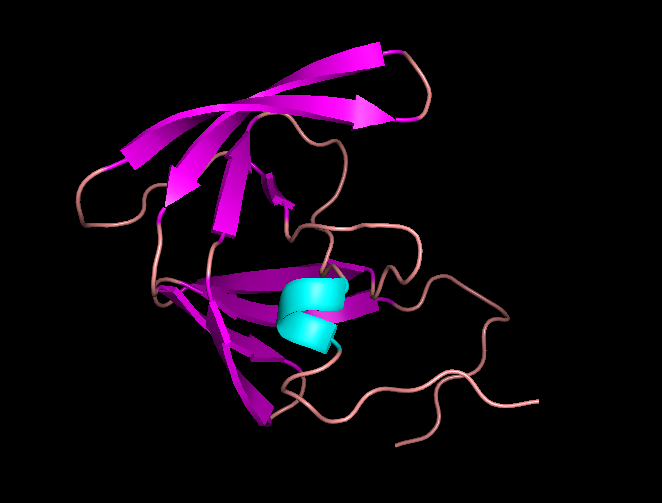 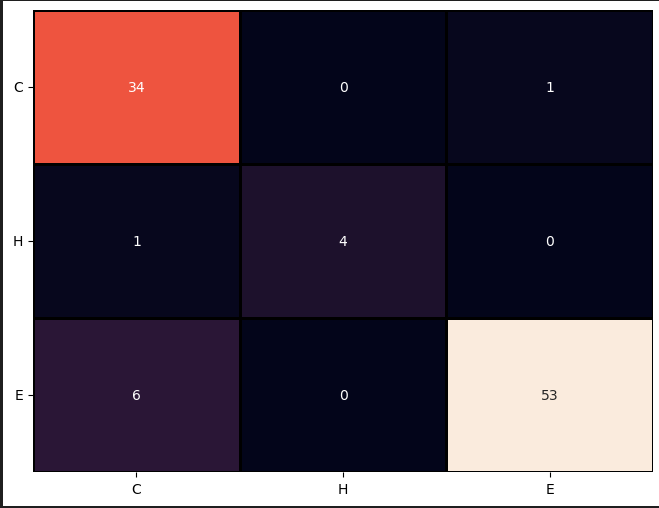

1/1 [==============================] - 0s 314ms/step


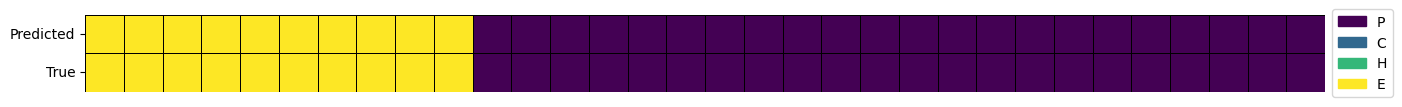

In [ ]:
plot_prediction(66)

1/1 [==============================] - 0s 18ms/step


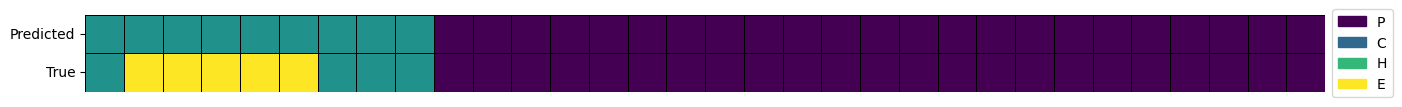

In [ ]:
plot_prediction(2)

1/1 [==============================] - 0s 18ms/step


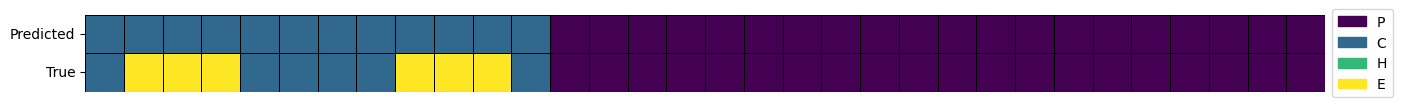

In [ ]:
plot_prediction(3)

1/1 [==============================] - 0s 19ms/step


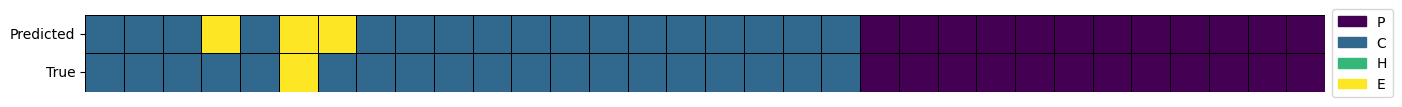

In [ ]:
plot_prediction(4)

In [ ]:
def plot_confusion_matrix(i):
    p1 = np.argmax(model.predict(X_test[i:i+1]), axis=-1)[0]
    y1 = np.argmax(y_test[i:i+1], axis=-1)[0]
    
    p1 = p1[y1 > 0]
    y1 = y1[y1 > 0]

    c = np.zeros((3, 3))
    for i in range(1, 4):
        for j in range(1, 4):
            c[i-1, j-1] = np.sum((p1 == i) & (y1 == j))
    
    _, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(c, annot=True, linewidths=1, linecolor='black', cbar=False)

    ax.set_xticklabels(['C', 'H', 'E'])
    ax.set_yticklabels(['C', 'H', 'E'], rotation=0)

    plt.show()

1/1 [==============================] - 0s 19ms/step


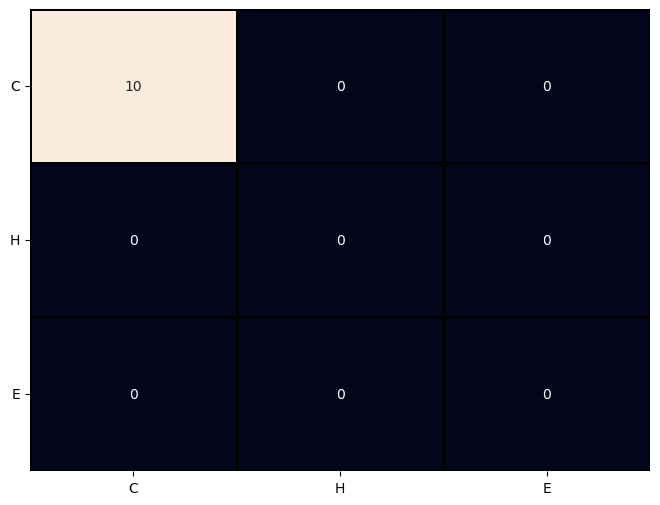

In [ ]:
plot_confusion_matrix(66)

In [ ]:
# Remove all whitespaces and make every letter capital
seq = ' '.join(tokenizer_in.sequences_to_texts(X_test[66:67])[0]).replace(' ', '').upper()
seq

'MVWGPDPLYV'